# 105.6. Create custom coadd images

<div>
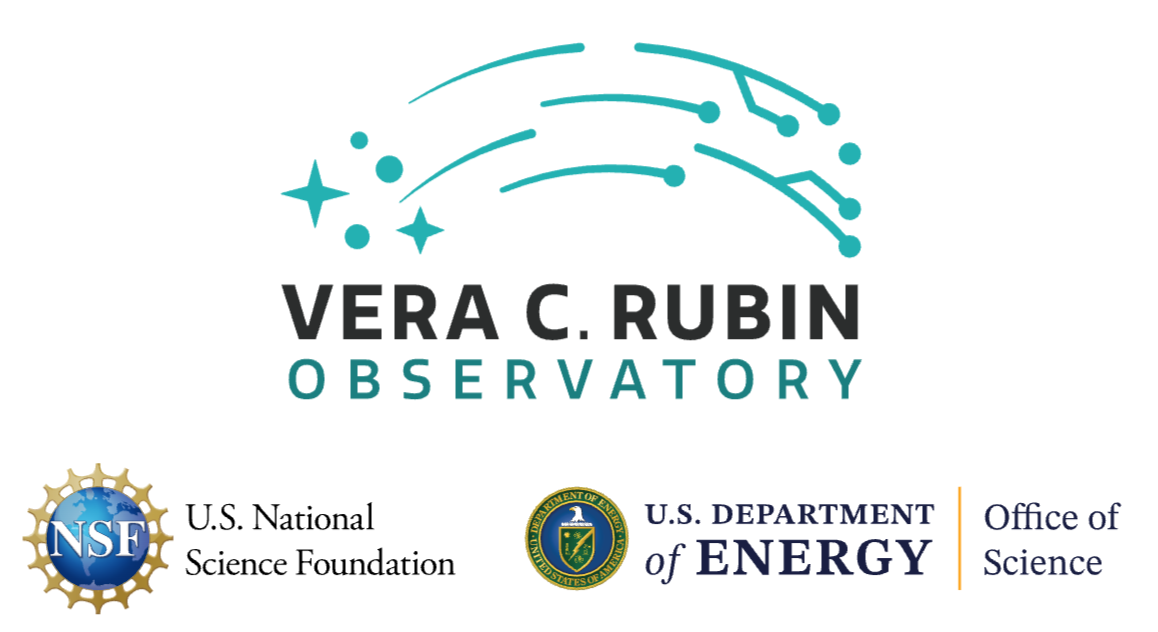
</div>
For the Rubin Science Platform at data.lsst.cloud. <br>
Data Release: DP1 <br>
Container Size: large <br>
LSST Science Pipelines version: r29.1.1 <br>
Last verified to run: 2025-07-29 <br>
Repository: <a href="https://github.com/lsst/tutorial-notebooks">github.com/lsst/tutorial-notebooks</a> <br>

**Learning objective:** How to create a custom coadd from a desired subset of DP1 exposures.

**LSST data products:** `visit_image`, `visit_table`, `deep_coadd_predetection`

**Packages:** `lsst.daf.butler`, `lsst.ctrl.mpexec`, `lsst.pipe.base`

**Credit:** Originally developed by the Rubin Community Science team with assistance from Rubin Data Management.  Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

**Get Support:**
Everyone is encouraged to ask questions or raise issues in the 
<a href="https://community.lsst.org/c/support">Support Category</a> 
of the Rubin Community Forum.
Rubin staff will respond to all questions posted there.

## 1. Introduction

In certain scientific applications, it may be desirable to make a custom coadd of DP1 exposures that, for example, includes only exposures before or after some date. For instance, when looking for any potential faint precursor of a transient of interest, coadding only the subset of exposures prior to the date of the transient's brightening could reveal such a precursor even if the precursor is fainter than the single-exposure depth.

**This tutorial** illustrates the process of selecting a subset of DP1 exposures at a given sky location and creating a custom coadd based on the curated list of desired input exposures. 


**Related tutorials:**  The first 100-level tutorial in this series provides a basic introduction to how to use the LSST Science Pipelines; later tutorials in this series demonstrate other image analysis techniques available with the LSST Science Pipelines.

### 1.1. Import packages

From the [LSST Science Pipelines](https://pipelines.lsst.io/), import modules for data access via the Butler (`lsst.daf.butler`), for image display (`lsst.afw.display`), pipeline definition (`lsst.pipe.base`), and pipeline execution (`lsst.ctrl.mpexec`).  In addition, import the [`matplotlib`](https://matplotlib.org/) and `getpass` modules.

In [1]:
import os
from pathlib import Path
from lsst.daf.butler import Butler
from lsst.ctrl.mpexec import SimplePipelineExecutor
from lsst.pipe.base import Pipeline

import getpass

import lsst.afw.display as afwDisplay
import matplotlib.pyplot as plt

### 1.2. Define parameters and functions

Create an instance of the Butler with the repository and collection for DP1, and assert that it exists.

In [2]:
butler = Butler("dp1", collections="LSSTComCam/DP1")
assert butler is not None

Perform custom coaddition at the center of the Extended Chandra Deep Field South (ECDFS), which offers a large number of input exposures from which to subselect. Use r-band. The ECDFS overview tutorial notebook shows that the tract and patch corresponding to the center of ECDFS is (tract, patch) = (5063, 34).

In [3]:
my_filter = 'r'
my_tract = 5063
my_patch = 34

Configure plotting to use matplotlib to display figures directly within this notebook.

In [4]:
afwDisplay.setDefaultBackend('matplotlib')

## 2. Select input exposures



Use the standard (i.e., not customized) DP1 deep coadd at the center of ECDFS to access the full list of available DP1 r-band exposures at this sky location. Start by retrieving the relevant deep coadd using the Butler.

In [5]:
my_dataId = {'band': my_filter, 'tract': my_tract, 'patch': my_patch}
my_deepCoadd = butler.get('deep_coadd', dataId=my_dataId)

Get the coadd inputs, which include the list of input exposures.

In [6]:
deep_coadd_inputs = my_deepCoadd.getInfo().getCoaddInputs()

The coadd inputs object's `.visit` attribute contains the full list of r-band input exposures used to make the standard DP1 custom coadd for this tract/patch. Check how many exposures contribute to the standard DP1 deep coadd at the center of ECDFS.

In [7]:
len(deep_coadd_inputs.visits)

230

Convert the deep coadd's input visits to an astropy `Table`.

In [8]:
deep_coadd_visits = deep_coadd_inputs.visits.asAstropy()

*Option*: see what the deep coadd's visit table looks like laid out in terms of rows and columns.

In [9]:
# deep_coadd_visits

The custom coadd will use a subset of input exposures based on timestamp. Check what columns are available from the deep coadd's visit list, to determine whether timestamp information is available there.

In [10]:
deep_coadd_visits.colnames

['id',
 'bbox_min_x',
 'bbox_min_y',
 'bbox_max_x',
 'bbox_max_y',
 'goodpix',
 'weight',
 'filter']

The deep coadd's visit list doesn't include timestamp information. Timestamp information will be retrieved by looking up the relevant visit `id` values in the DP1 `visit_table`, because the DP1 `visit_table` contains more extensive metadata about every exposure in DP1.

Retrieve the DP1 `visit_table`.

In [11]:
visitTableRef = list(butler.registry.queryDatasets('visit_table'))
visitTable = butler.get(visitTableRef[0])

Check the DP1 `visit_table` column names to verify that timestamp information is available.

In [12]:
visitTable.colnames

['visitId',
 'visit',
 'physical_filter',
 'band',
 'ra',
 'dec',
 'decl',
 'skyRotation',
 'azimuth',
 'altitude',
 'zenithDistance',
 'airmass',
 'expTime',
 'expMidpt',
 'expMidptMJD',
 'obsStart',
 'obsStartMJD']

The last five columns contain timestamp-related information.  Use `expMidptMJD`, the exposure midpoint Modified Julian Date (MJD), to select the subsample of exposures to be used for building the custom coadd. Put the rows of the deep coadd visits table and the DP1 visit table in correspondence by matching up the `id` column of the former to the `visitId` column of the latter. With the MJD values retrieved, add these as a new column to the table of deep coadd visits.

In [13]:
visitTable.add_index('visitId')
deep_coadd_visits_mjds = visitTable.loc[deep_coadd_visits['id']]['expMidptMJD']
deep_coadd_visits['expMidptMJD'] = deep_coadd_visits_mjds

Make a histogram of the MJD values of the exposures contributing to the DP1 deep coadd at the center of ECDFS.

Text(0, 0.5, 'number of input exposures')

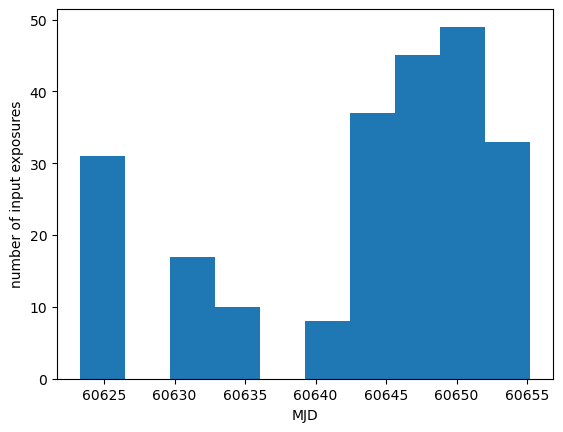

In [14]:
plt.hist(deep_coadd_visits['expMidptMJD'])
plt.xlabel('MJD')
plt.ylabel('number of input exposures')

> Figure 1: Histogram of input exposure dates in MJD.

Imagining that a transient of interest "turned on" around MJD = 60630 (roughly 2024 November 16), create a custom coadd isolating any precursor to the transient by selecting only exposures with MJD < 60627.

In [15]:
early_exposures = deep_coadd_visits[deep_coadd_visits['expMidptMJD'] < 60630]

Per the above histogram, selecting exposures before MJD = 60630 isolates the first ~30+ exposures. For the sake of relatively rapid custom coadd creation, downselect to only 8 of these ~30+ early-time exposures. Making a custom coadd with 30+ input exposures is possible, but would require a longer coaddition processing time (and a larger peak memory).

In [16]:
n_exposures_max = 8
early_exposure_ids = early_exposures[0:n_exposures_max]['id']
early_exposure_ids

2024110800246
2024110800247
2024110800250
2024110800251
2024110800254
2024110800255
2024110800258
2024110800259


## 3. Create the custom coadd

### 3.1. Define and configure the pipeline

Creating the custom coadd means running a subset of the full DP1 "Data Release Production" (DRP) pipeline on the desired list of input exposures, for the tract/patch at the center of ECDFS. Refer to the first 100-level tutorial in this series for more background information about defining pipelines using YAML files. For custom coaddition, the four processing steps to run are `makeDirectWarp`, `assembleDeepCoadd`, `makePsfMatchedWarp`, and `selectDeepCoaddVisits`. Thus, create a custom pipeline with a Uniform Resource Identifier (URI) that consists of the name of the DP1 DRP pipeline's YAML file followed by `#` and then a comma separated list of the four processing steps to be executed.

In [17]:
drp_yaml_file = "$DRP_PIPE_DIR/pipelines/LSSTComCam/DRP-v2-compat.yaml"
uri = drp_yaml_file + "#makeDirectWarp,assembleDeepCoadd,makePsfMatchedWarp,selectDeepCoaddVisits"
pipeline = Pipeline.from_uri(uri)

The DP1 dataset available to users does not contain all intermediate data products. To work around this, use pipeline configuration overrides to ensure that custom coaddition will draw needed metadata information directly from the calibrated exposures rather than other intermediate products.

In [18]:
pipeline.addConfigOverride('makeDirectWarp', 'useVisitSummaryPsf', False)
pipeline.addConfigOverride('makeDirectWarp', 'useVisitSummaryPhotoCalib', False)
pipeline.addConfigOverride('makeDirectWarp', 'useVisitSummaryWcs', False)
pipeline.addConfigOverride('makeDirectWarp', 'connections.calexp_list', 'visit_image')

### 3.2. Make a writable Butler

Use the convention `u/<Your User Name>/<Collection Identifier>` to set up a new Butler output collection for the custom coadd. Access your username through the `getpass` module.

In [19]:
my_username = getpass.getuser()
print(my_username)

ameisner


Construct the output collection name.

In [20]:
my_collection_identifier = 'custom_coadd_ecdfs'
my_outputCollection = 'u/'+my_username+'/'+my_collection_identifier
my_outputCollection

'u/ameisner/custom_coadd_ecdfs'

Creating the writable Butler requires first creating a pipeline executor, which in turn requires a query string defining the specific input data to use. Construct the custom coaddition query string specifying the coadd footprint (tract and patch), as well as the custom list of input exposures. The custom subset of visit identifiers is expressed within the query as a comma-separated list. The skymap value of `lsst_cells_v1` is simply the sky tiling that has been used in general for DP1.

In [21]:
my_visits_tupleString = "("+",".join(early_exposure_ids.astype(str))+")"
query_string = """tract = {} AND patch = {} AND visit IN {} AND skymap = 'lsst_cells_v1'
                """.format(my_tract, my_patch, my_visits_tupleString)
print(query_string)

tract = 5063 AND patch = 34 AND visit IN (2024110800246,2024110800247,2024110800250,2024110800251,2024110800254,2024110800255,2024110800258,2024110800259) AND skymap = 'lsst_cells_v1'
                


Create a `SimplePipelineExecutor` object that will enable running the custom coaddition pipeline. The `SimplePipelineExecutor`'s inputs are the pipeline structural definition, the DP1 Butler object, the output collection name, and the query string.

In [22]:
executor = SimplePipelineExecutor.from_pipeline(pipeline, butler=butler,
                                                output=my_outputCollection, where=query_string)

Users cannot write to the main DP1 Butler repository. Instead, make a writable repository where custom coadd outputs will be written. The call to `use_local_butler` creates a new directory that will contain the local Butler repository, within the `$SCRATCH_DIR` temporary space that gets deleted weekly. Use this temporary space because the custom coadd processing produces of order a gigabyte of intermediate files.

In [23]:
local_repo_path = Path(os.getenv("SCRATCH_DIR"), "my_local_repo")
out_butler = executor.use_local_butler(local_repo_path)

### 3.3. Run the coadd processing

Use the executor to run the custom coadd processing. This processing may take several minutes to complete and prints many lines of logging output along the way.

In [24]:
executor.run(register_dataset_types=True)

Retrieve the custom deep coadd from the local Butler repository. Retrieve the `deep_coadd_predetection` dataset type, as that's the output type that the custom coaddition generated.

In [25]:
deepCoadd = out_butler.get('deep_coadd_predetection', tract=my_tract, patch=my_patch,
                           band='r', instrument='LSSTComCam', skymap='lsst_cells_v1',
                           collections=executor.quantum_graph.metadata["output_run"])

Display a grayscale image of the custom deep coadd. Note that this custom deep coadd is shallower than the deep coadd provided by default within DP1 for this same tract/patch, as the latter uses all available r-band DP1 exposures.

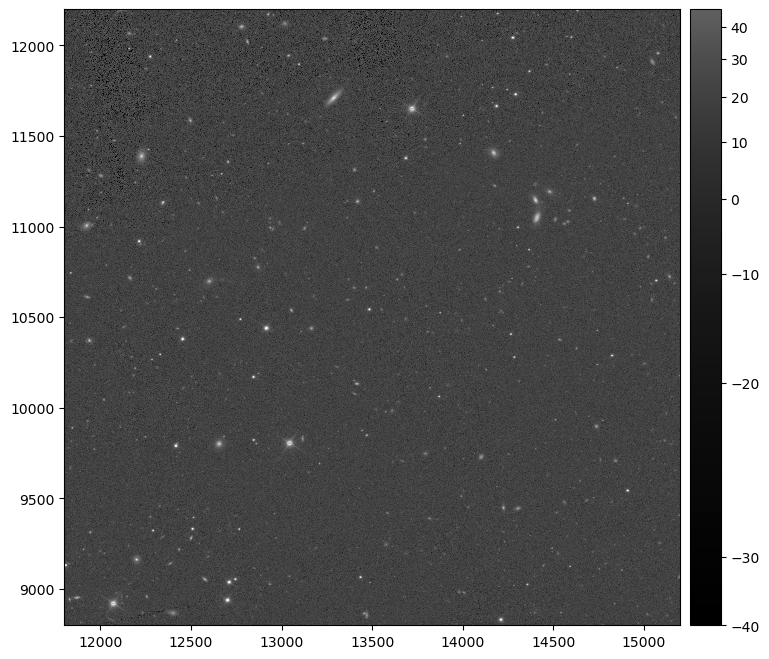

In [26]:
fig = plt.figure(figsize=(10, 8))
afw_display = afwDisplay.Display(frame=fig)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(deepCoadd.image)
plt.gca().axis('on')
plt.show()

> Figure 2: The custom `deep_coadd` image using only the selected subset of input visit images.

### 3.4. Copy the custom coadd output file

The writable Butler repository used for custom coaddition is located within a temporary storage area. The Butler `retrieveArtifacts` method can be used to retrieve a copy of just the custom coadd output file, without copying intermediate files generated by the processing, and placing the custom coadd output file in a desired location. This can be useful to preserve the custom coadd image file without filling up a significant amount of disk quota in a permanent location. Start by retrieving the dataset reference for the custom coadd image output file.

In [27]:
refs = out_butler.query_datasets('deep_coadd_predetection',
                                 collections=executor.quantum_graph.metadata["output_run"])

As an example, choose to put the copy of the custom coadd output file in your scratch space area.

In [28]:
outdir = os.getenv("SCRATCH_DIR")

*Option*: instead choose to copy the custom coadd output file to your home directory, where it will not be deleted within a week.

In [29]:
# outdir = os.getenv("HOME")

Copy the FITS file containing the custom coadd image to the desired location.

In [30]:
out_butler.retrieveArtifacts(refs, outdir, preserve_path=False, transfer="copy", overwrite=True)

[ResourcePath("file:///deleted-sundays/ameisner/deep_coadd_predetection_5063_34_r_lsst_cells_v1_u_ameisner_custom_coadd_ecdfs_20250729T210408Z.fits")]

To free up space, delete the writable Butler repository used for custom coaddition. If you wish to continue exploring the writable Butler repository then the following cell can be skipped, though note that the local Butler repo will still be deleted within a week because it is within temporary scratch space. In general, be very careful about any `rm -r` or similar commands that you run on RSP, as there is potential for inadvertently deleting files you wish to retain.

*Option*: Skip the final cell below if you wish to continue working with variables previously defined in this notebook and/or continue using your writable Butler repo.

In [31]:
%reset -f
! rm -r $SCRATCH_DIR/my_local_repo